In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2023-01-08 16:58:38.559370: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-08 16:58:52.151036: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-01-08 16:58:52.169004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-08 16:58:52.169069: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-08 16:58:52.173952: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-01-08 16:58:52.178227: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
@tf.function
def derivatives(pinn, x):
    y = pinn.net(x)
    p1, p2 = pinn.gradients(x, y)
    return y, p1, p2

# Two-dimensional data

In [3]:
def Gaussian_2d(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return np.exp(-(x-locx)**2/(2*scalex**2)-(y-locy)**2/(2*scaley**2))

def Gaussian_2d_df_dx(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(x-locx)/(scalex**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_df_dy(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(y-locy)/(scaley**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_d2f_dx2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scalex**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley)
            -((x-locx)/(scalex**2))*Gaussian_2d_df_dx(x, y, locx, locy, scalex, scaley))

def Gaussian_2d_d2f_dy2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scaley**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley) 
            -((y-locy)/(scaley**2))*Gaussian_2d_df_dy(x, y, locx, locy, scalex, scaley))


data_2d_x = np.linspace(-2, 2, 128)[:,np.newaxis].astype(np.float32)
data_2d_y = np.linspace(-2, 2, 128)[:,np.newaxis].astype(np.float32)
X,Y = np.meshgrid(data_2d_x, data_2d_y,indexing='ij')

data_input = np.concatenate([X.flatten()[:,np.newaxis],
                             Y.flatten()[:,np.newaxis]], 
                              axis=1)

# Equal dispersion

In [4]:
data_2d_z_gaussian_equal = Gaussian_2d(X, Y, 0.0, 0.5, .5, .5)

data_2d_df_dx = Gaussian_2d_df_dx(X, Y, 0.0, 0.5, .5, .5)
data_2d_df_dy = Gaussian_2d_df_dy(X, Y, 0.0, 0.5, .5, .5)

data_2d_d2f_dx2 = Gaussian_2d_d2f_dx2(X, Y, 0.0, 0.5, .5, .5)
data_2d_d2f_dy2 = Gaussian_2d_d2f_dy2(X, Y, 0.0, 0.5, .5, .5)

ds_gaussian_2d_equal = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian_equal.flatten()[:,np.newaxis]], 
                              axis=1))

In [5]:
def plot(X, Y, Z, title=""):
    plt.title(title)
    plt.contourf(X, Y, Z)
    plt.colorbar()

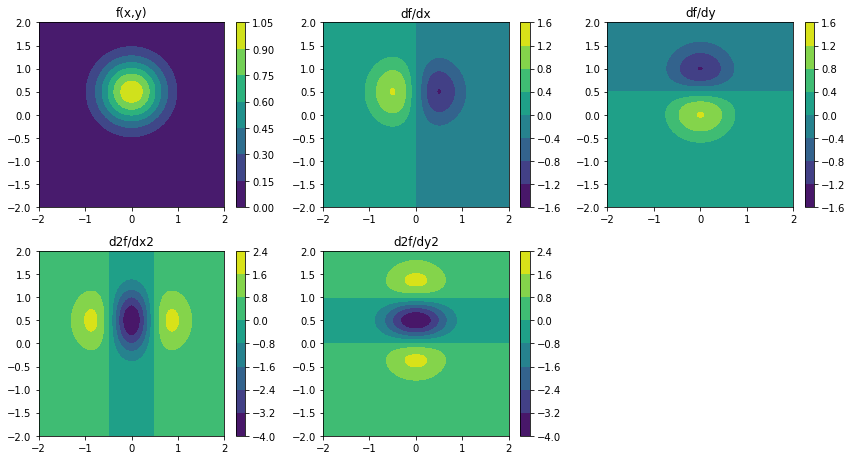

In [6]:
_ = plt.figure(figsize=(12,6.5))
plt.subplot(231)
plot(X, Y, data_2d_z_gaussian_equal, "f(x,y)")
plt.subplot(232)
plot(X, Y, data_2d_df_dx, "df/dx")
plt.subplot(233)
plot(X, Y, data_2d_df_dy, "df/dy")
plt.subplot(234)
plot(X, Y, data_2d_d2f_dx2, "d2f/dx2")
plt.subplot(235)
plot(X, Y, data_2d_d2f_dy2, "d2f/dy2")
plt.tight_layout()
plt.show()

In [14]:
layers1 = [2, 128, 128, 1]
pinn1 = tu.NN(layers1, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

# Initial output of an untrained network

In [15]:
def RMSE(pred, actual, sqrt=True):
    if sqrt:
        return np.sqrt(np.mean((pred-actual)**2))
    else:
        return np.mean((pred-actual)**2)

In [16]:
def to_2d(x):
    return x.reshape((data_2d_x.shape[0], data_2d_x.shape[0]))

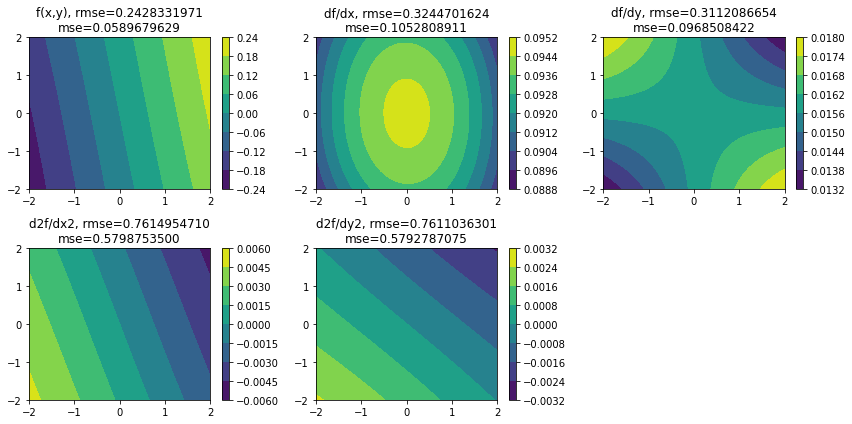

In [17]:
y, y_der_1, y_der_2 = derivatives(pinn1, data_input)


_ = plt.figure(figsize=(12,6))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian_equal, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian_equal, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

# Train the model

In [18]:
loss1 = Observation_Loss(layers1, residual_ret_names=("f(x,y)",), print_precision = ".10f")
model1 = tu.TINN(pinn1, [loss1], L2(),
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results1 = model1.train(200000+1, 4096, ds_gaussian_2d_equal, 
                        print_interval=5000, stop_threshold=5e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.2279021470, total regularised loss: 0.2279021442
Observation_Loss -> 
(1)  f(x,y): 0.0569755367 
Time taken: 1.58s

Start of epoch 5000
total loss: 0.0024345852, total regularised loss: 0.0024345852
Observation_Loss -> 
(1)  f(x,y): 0.0006086463 
Time taken: 124.49s

Start of epoch 10000
total loss: 0.0002677157, total regularised loss: 0.0002677157
Observation_Loss -> 
(1)  f(x,y): 0.0000669289 
Time taken: 128.54s

Start of epoch 15000
total loss: 0.0001446921, total regularised loss: 0.0001446921
Observation_Loss -> 
(1)  f(x,y): 0.0000361730 
Time taken: 130.50s

Start of epoch 20000
total loss: 0.0001984647, total regularised loss: 0.0001984648
Observation_Loss -> 
(1)  f(x,y): 0.0000496162 
Time taken: 126.18s

Start of epoch 25000
total loss: 0.0000724862, total regularised loss: 0.0000724862
Observation_Loss -> 
(1)  f(x,y): 0.0000181216 
Time taken: 128.55s

Start of epoch 30000
total loss: 0.0000543382, total regularised loss: 0.0000543382
Obse

In [30]:
results2 = model1.train(100000+1, 4096, ds_gaussian_2d_equal, 
                        print_interval=5000, stop_threshold=5e-7,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.0000425732, total regularised loss: 0.0000425732
Observation_Loss -> 
(1)  f(x,y): 0.0000106433 
Time taken: 1.02s

Start of epoch 5000
total loss: 0.0000226081, total regularised loss: 0.0000226081
Observation_Loss -> 
(1)  f(x,y): 0.0000056520 
Time taken: 120.49s

Start of epoch 10000
total loss: 0.0000202458, total regularised loss: 0.0000202458
Observation_Loss -> 
(1)  f(x,y): 0.0000050614 
Time taken: 120.36s

Start of epoch 15000
total loss: 0.0007752296, total regularised loss: 0.0007752296
Observation_Loss -> 
(1)  f(x,y): 0.0001938074 
Time taken: 120.98s

Start of epoch 20000
total loss: 0.0000172557, total regularised loss: 0.0000172557
Observation_Loss -> 
(1)  f(x,y): 0.0000043139 
Time taken: 119.44s

Start of epoch 25000
total loss: 0.0000148822, total regularised loss: 0.0000148822
Observation_Loss -> 
(1)  f(x,y): 0.0000037206 
Time taken: 120.96s

Start of epoch 30000
total loss: 0.0000134618, total regularised loss: 0.0000134618
Obse

In [31]:
model1.save(".", "Gaussian_2D_symmetric_f_x_y")

# After training

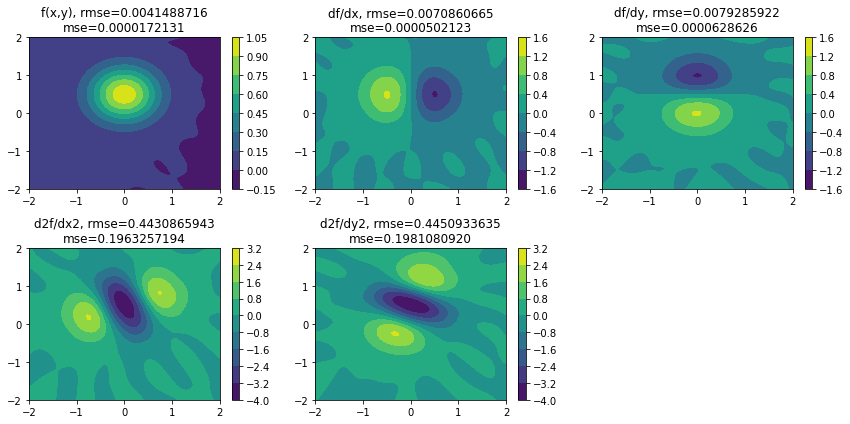

In [32]:
y, y_der_1, y_der_2 = derivatives(pinn1, data_input)


_ = plt.figure(figsize=(12,6))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian_equal, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian_equal, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

# Asymmetrical: elongated in the X direction

In [33]:
data_2d_z_gaussian_elongated_x = Gaussian_2d(X, Y, 0.0, 0.5, 1., .5)

data_2d_df_dx_elongated_x = Gaussian_2d_df_dx(X, Y, 0.0, 0.5, 1., .5)
data_2d_df_dy_elongated_x = Gaussian_2d_df_dy(X, Y, 0.0, 0.5, 1., .5)

data_2d_d2f_dx2_elongated_x = Gaussian_2d_d2f_dx2(X, Y, 0.0, 0.5, 1., .5)
data_2d_d2f_dy2_elongated_x = Gaussian_2d_d2f_dy2(X, Y, 0.0, 0.5, 1., .5)

ds_gaussian_2d_elongated_x = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian_elongated_x.flatten()[:,np.newaxis]], 
                              axis=1))

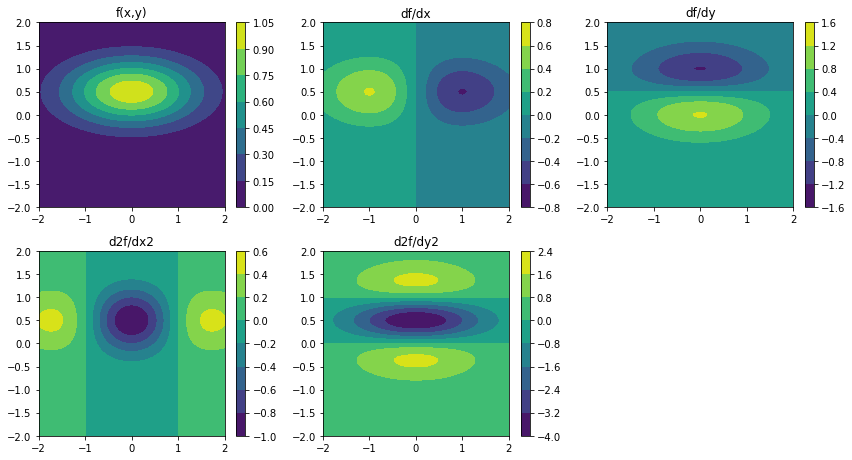

In [25]:
_ = plt.figure(figsize=(12,6.5))
plt.subplot(231)
plot(X, Y, data_2d_z_gaussian_elongated_x, "f(x,y)")
plt.subplot(232)
plot(X, Y, data_2d_df_dx_elongated_x, "df/dx")
plt.subplot(233)
plot(X, Y, data_2d_df_dy_elongated_x, "df/dy")
plt.subplot(234)
plot(X, Y, data_2d_d2f_dx2_elongated_x, "d2f/dx2")
plt.subplot(235)
plot(X, Y, data_2d_d2f_dy2_elongated_x, "d2f/dy2")
plt.tight_layout()
plt.show()

In [34]:
layers2 = [2, 128, 128, 1]
pinn2 = tu.NN(layers2, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

In [35]:
loss2 = Observation_Loss(layers2, residual_ret_names=("f(x,y)",), print_precision = ".10f")
model2 = tu.TINN(pinn2, [loss2], L2(),
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results2 = model2.train(200000+1, 4096, ds_gaussian_2d_elongated_x, 
                        print_interval=5000, stop_threshold=5e-7,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.4349001665, total regularised loss: 0.4349001646
Observation_Loss -> 
(1)  f(x,y): 0.1087250416 
Time taken: 1.73s

Start of epoch 5000
total loss: 0.0004965240, total regularised loss: 0.0004965240
Observation_Loss -> 
(1)  f(x,y): 0.0001241310 
Time taken: 125.10s

Start of epoch 10000
total loss: 0.0000727471, total regularised loss: 0.0000727471
Observation_Loss -> 
(1)  f(x,y): 0.0000181868 
Time taken: 126.86s

Start of epoch 15000
total loss: 0.0000409337, total regularised loss: 0.0000409337
Observation_Loss -> 
(1)  f(x,y): 0.0000102334 
Time taken: 126.26s

Start of epoch 20000
total loss: 0.0000273742, total regularised loss: 0.0000273742
Observation_Loss -> 
(1)  f(x,y): 0.0000068435 
Time taken: 128.54s

Start of epoch 25000
total loss: 0.0000207550, total regularised loss: 0.0000207550
Observation_Loss -> 
(1)  f(x,y): 0.0000051888 
Time taken: 124.88s

Start of epoch 30000
total loss: 0.0000170591, total regularised loss: 0.0000170591
Obse

In [36]:
model1.save(".", "Gaussian_2D_elongetd_x_f_x_y")

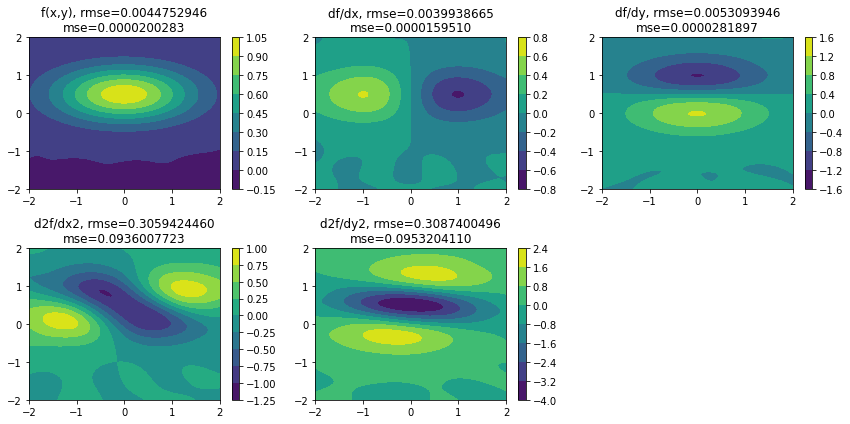

In [37]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(12,6))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian_elongated_x, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian_elongated_x, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx_elongated_x, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx_elongated_x, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy_elongated_x, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy_elongated_x, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2_elongated_x, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2_elongated_x, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2_elongated_x, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2_elongated_x, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

# Asymmetrical: elongated in the Y direction

In [38]:
data_2d_z_gaussian_elongated_y = Gaussian_2d(X, Y, 0.0, 0.0, .5, 1.0)

data_2d_df_dx_elongated_y = Gaussian_2d_df_dx(X, Y, 0.0, 0.0, .5, 1.0)
data_2d_df_dy_elongated_y = Gaussian_2d_df_dy(X, Y, 0.0, 0.0, .5, 1.0)

data_2d_d2f_dx2_elongated_y = Gaussian_2d_d2f_dx2(X, Y, 0.0, 0.0, .5, 1.0)
data_2d_d2f_dy2_elongated_y = Gaussian_2d_d2f_dy2(X, Y, 0.0, 0.0, .5, 1.0)

ds_gaussian_2d_elongated_y = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian_elongated_y.flatten()[:,np.newaxis]], 
                              axis=1))

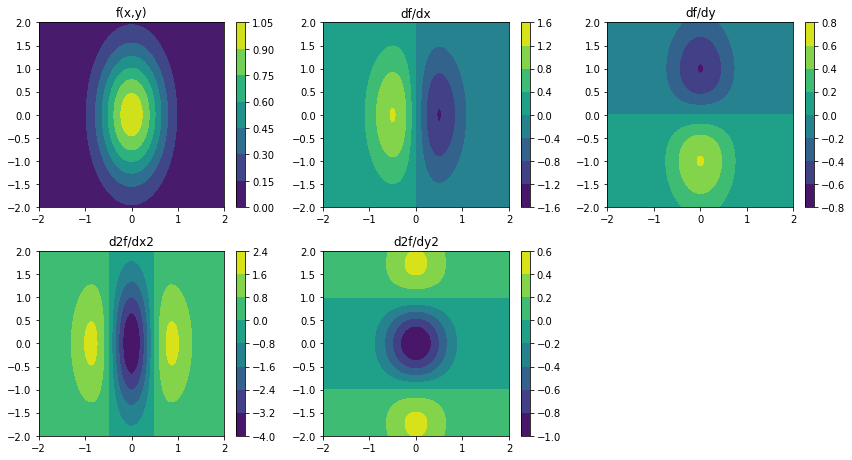

In [29]:
_ = plt.figure(figsize=(12,6.5))
plt.subplot(231)
plot(X, Y, data_2d_z_gaussian_elongated_y, "f(x,y)")
plt.subplot(232)
plot(X, Y, data_2d_df_dx_elongated_y, "df/dx")
plt.subplot(233)
plot(X, Y, data_2d_df_dy_elongated_y, "df/dy")
plt.subplot(234)
plot(X, Y, data_2d_d2f_dx2_elongated_y, "d2f/dx2")
plt.subplot(235)
plot(X, Y, data_2d_d2f_dy2_elongated_y, "d2f/dy2")
plt.tight_layout()
plt.show()

In [39]:
layers3 = [2, 128, 128, 1]
pinn3 = tu.NN(layers3, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

In [40]:
loss3 = Observation_Loss(layers3, residual_ret_names=("f(x,y)",), print_precision = ".10f")
model3 = tu.TINN(pinn3, [loss3], L2(),
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results3 = model3.train(200000+1, 4096, ds_gaussian_2d_elongated_y, 
                        print_interval=5000, stop_threshold=5e-7,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.4514427595, total regularised loss: 0.4514427781
Observation_Loss -> 
(1)  f(x,y): 0.1128606899 
Time taken: 1.94s

Start of epoch 5000
total loss: 0.0031619915, total regularised loss: 0.0031619915
Observation_Loss -> 
(1)  f(x,y): 0.0007904979 
Time taken: 121.93s

Start of epoch 10000
total loss: 0.0015385438, total regularised loss: 0.0015385437
Observation_Loss -> 
(1)  f(x,y): 0.0003846360 
Time taken: 122.90s

Start of epoch 15000
total loss: 0.0000833667, total regularised loss: 0.0000833667
Observation_Loss -> 
(1)  f(x,y): 0.0000208417 
Time taken: 122.87s

Start of epoch 20000
total loss: 0.0000333717, total regularised loss: 0.0000333717
Observation_Loss -> 
(1)  f(x,y): 0.0000083429 
Time taken: 122.94s

Start of epoch 25000
total loss: 0.0000752460, total regularised loss: 0.0000752460
Observation_Loss -> 
(1)  f(x,y): 0.0000188115 
Time taken: 123.17s

Start of epoch 30000
total loss: 0.0000298425, total regularised loss: 0.0000298425
Obse

In [41]:
model1.save(".", "Gaussian_2D_elongetd_y_f_x_y")

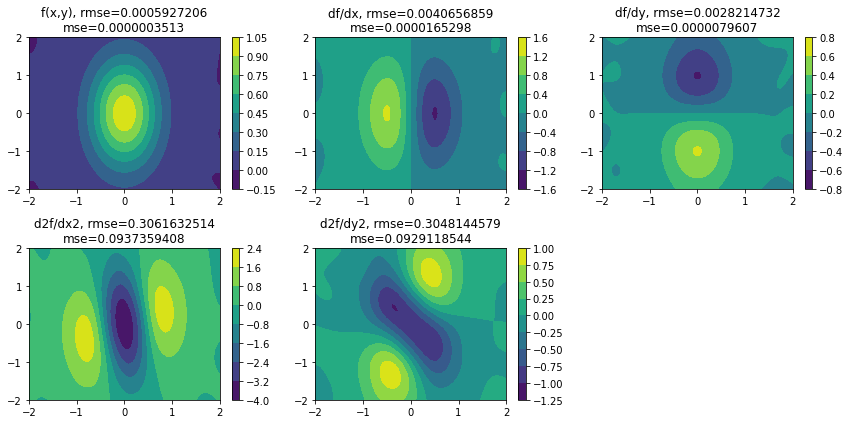

In [42]:
y, y_der_1, y_der_2 = derivatives(pinn3, data_input)


_ = plt.figure(figsize=(12,6))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian_elongated_y, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian_elongated_y, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx_elongated_y, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx_elongated_y, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy_elongated_y, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy_elongated_y, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2_elongated_y, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2_elongated_y, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2_elongated_y, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2_elongated_y, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()